# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data collection

This module uses metadata which defines a pair of goal and actions lists as well as initial graphs to fetch multiagent observation data for training. 

## Install VirtualHome (Colab)

In [2]:
import matplotlib.pyplot as plt
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !pip install git+https://github.com/xavierpuigf/colabstreamer
    !git clone https://github.com/xavierpuigf/virtualhome.git
    import colabstreamer
    colabstreamer.config_all()
    _xorg = colabstreamer.open_xorg()
    display = "0"
else:  
    import getpass
    import os
    password = getpass.getpass()
    %cd ../..
    !git clone https://github.com/xavierpuigf/virtualhome.git
    %cd virtualhome/helper_scripts
    command = 'sudo -S python startx.py 1'
    display = "1"
    os.popen(command, 'w').write(password+'\n')
    %cd ../../
    

Running on CoLab
  Cloning https://github.com/xavierpuigf/colabstreamer to /tmp/pip-req-build-u893l8bi
  Running command git clone -q https://github.com/xavierpuigf/colabstreamer /tmp/pip-req-build-u893l8bi
     |████████████████████████████████| 179 kB 6.8 MB/s 
  Created wheel for colabstreamer.py: filename=colabstreamer.py-0.1-py3-none-any.whl size=3830 sha256=71fc698f60672fb887a60f7f6e29e9cf0e40c0de7395ec6cdaf808a0d487505a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jbo_oh9b/wheels/7e/df/62/68e8e5813ab1ac489ca123bc4051459c61ba909df0ec7ac404
Successfully built colabstreamer.py
Cloning into 'virtualhome'...
remote: Enumerating objects: 27204, done.
remote: Counting objects: 100% (588/588), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 27204 (delta 381), reused 558 (delta 366), pack-reused 26616
Receiving objects: 100% (27204/27204), 287.36 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (17650/17650), done.
Will Install xvfb
Will Install xserver-xorg
Wi

In [3]:
# Download the simulator
! wget http://virtual-home.org/linux_exec.zip
! unzip -q linux_exec.zip
import os
fpath = os.getcwd()

--2022-04-23 23:24:27--  http://virtual-home.org/linux_exec.zip
Resolving virtual-home.org (virtual-home.org)... 128.30.100.223
Connecting to virtual-home.org (virtual-home.org)|128.30.100.223|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 901763908 (860M) [application/zip]
Saving to: ‘linux_exec.zip’

linux_exec.zip      100%[===================>] 859.99M  2.75MB/s    in 5m 59s  

2022-04-23 23:30:26 (2.40 MB/s) - ‘linux_exec.zip’ saved [901763908/901763908]



In [4]:
fpath

'/content'

In [6]:
#if this cell fails run it twice
%matplotlib notebook
import IPython.display
import sys
sys.path.append('./virtualhome')
from simulation.unity_simulator import comm_unity
import demo.utils_demo as utils_demo

## Import Virtualhome Library

In [7]:
%cd virtualhome

/content/virtualhome


In [8]:
%matplotlib notebook
%cd demo
import IPython.display
import glob
from utils_demo import *
from sys import platform
import sys
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append('../simulation')
from unity_simulator.comm_unity import UnityCommunication
from unity_simulator import utils_viz

/content/virtualhome/demo


## Convert word into templated sentence

In [9]:
!pip install num2words

     |████████████████████████████████| 101 kB 3.9 MB/s 


Convert goals

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
import re
from num2words import num2words
goal_trans = {'close': 'close to the',
              'facing': 'to the',
              'inside': 'inside the',
              'ontop': 'on the',
              }

def goal_translate(raw_goals):
    info = " ".join(raw_goals[1:-1].split()[1:])
    raw_goals = info[1:-1].split(') (')
    goals = ''
    for raw_sub_goals in raw_goals:
        word = raw_sub_goals.split(' ')
        goal = 'face ' if word[0] == 'facing' else 'grab ' if word[0] == 'grabbed' else 'put '
        if word[0] != 'grabbed':
            obj1 = word[1].split('_')[0]
            obj2 = word[2].split('_')[0]
            goal += '{} {} {}, '.format(obj1, goal_trans[word[0]], obj2)
            goals += goal
        else:
            obj = word[2].split('_')[0]
            goal += 'the {}, '.format(obj)
            goals += goal
    return goals[: -2]

goals = '(and  (inside clothespants_387  clothespile_413) (inside plate_195 kitchencabinet_235) (grabbed character_1 towel_68) (grabbed character_2 cereal_335))'
print(goal_translate(goals))

put clothespants inside the clothespile, put plate inside the kitchencabinet, grab the towel, grab the cereal


Convert history

In [22]:
verb_trans = {'standup': 'stood up',
              'walk': 'walked to',
              'sit': 'sit on',
              'grab': 'grabbed',
              'open': 'opened',
              'close': 'closed',
              'switchon': 'switched on',
              'switchoff': 'switched off',
              'put': ['put', 'on'],
              'putin': ['put', 'inside']}

def history_translate(history):
    if not history: return ''
    history_trans = 'I have '
    for sub in history:
        sub = sub.split(' ')
        if len(sub) == 2:
            history_trans +=  '{}, '.format(verb_trans[sub[1][1: -1]])
        elif len(sub) == 4:
            history_trans += '{} the {}, '.format(verb_trans[sub[1][1: -1]], sub[2][1: -1])
        elif len(sub) == 6:
            history_trans += '{} the {} {} the {}, '.format(verb_trans[sub[1][1: -1]][0], sub[2][1: -1], verb_trans[sub[1][1: -1]][1], sub[4][1: -1])
    history_trans = history_trans[:-2] + '.'
    return history_trans

history = ['<char0> [walk] <coffeepot> (161)', '<char0> [grab] <coffeepot> (161)']
history_translate(history)

'I have walked to the coffeepot, grabbed the coffeepot.'

## Get Partial Observations

Get virtualhome

Define the functions to add a character into the environment, get the objects that are visible in the character's view, obtain the name, state and positions of these objects, and get the edge information among objects

In [23]:
%cd ..

/content/virtualhome


In [24]:
#define env data parsers

def create_character(character, room):
    comm.add_character(character, initial_room=room)
    _, graph = comm.environment_graph()
    character_index = [node['id'] for node in graph['nodes'] if node['class_name'] == 'character'][-1]
    return character_index

def get_rooms_id(graph):
    #_, graph = comm.environment_graph()
    rooms_id = [node['id'] for node in graph['nodes'] if node['category'] == 'Rooms']
    return set(rooms_id)

def get_visible_objects_id(character_index , graph):
    #_, graph = comm.environment_graph()
    room_id = [edge['to_id'] for edge in graph['edges'] if edge['from_id'] == character_index and edge['relation_type'] == 'INSIDE'][-1]
    visible_objects_id_set = [edge['from_id'] for edge in graph['edges'] if edge['to_id'] == room_id and edge['relation_type'] == 'INSIDE' and edge['from_id'] != character_index]
    visible_objects_id_set = set(visible_objects_id_set)
    return visible_objects_id_set

def get_observations(character_index, visible_objects_id_set, graph):
    #_, graph = comm.environment_graph()
    character_position = [node for node in graph['nodes'] if node['id'] == character_index][0]['obj_transform']['position']
    ids, names, states, positions = [], [], [], []
    for node in graph['nodes']:
        if node['id'] in visible_objects_id_set:
            states_vector = [0, 0, 0, 0, 0, 0]
            if len(node['states']) == 0:
                states_vector[-1] = 1
            for state in node['states']:
                states_vector[state_index[state]] += 1
            ids += [node['id']]
            names += [node['class_name']]
            states += [states_vector]
            positions += [node['obj_transform']['position'] + list(np.array(node['obj_transform']['position']) - np.array(character_position))]
    
    #append to 256 (at most 255 nodes at an observation, with index 0 in training time being null object)
    while len(ids) < 256: 
        ids.append(-1)
        names.append("None")
        states.append([0,0,0,0,0,0])
        positions.append([0,0,0,0,0,0])

    return {'ids': ids[:256], 'names': names[:256], 'states':states[:256], 'positions':positions[:256]}


def get_relationships(character_index, observations, graph):
    #_, graph = comm.environment_graph()
    room_id = [edge['to_id'] for edge in graph['edges'] if edge['from_id'] == character_index and edge['relation_type'] == 'INSIDE'][-1]
    sitting_edges = set()
    close_edges = set()
    inside_edges = set()
    hold_edges = set()
    for edge in graph['edges']:
        if edge['to_id'] in observations['ids'] and edge['from_id'] == character_index:
            if edge['relation_type'] == 'SITTING':
                sitting_edges.add(edge['to_id'])
            elif edge['relation_type'] == 'CLOSE':
                close_edges.add(edge['to_id'])
            elif edge['relation_type'] == 'HOLDS_RH' or edge['relation_type'] == 'HOLDS_LH':
                hold_edges.add(edge['to_id'])
        if edge['from_id'] in observations:
            to_id_ind = np.where(observations['ids']==edge['to_id'])
            if edge['relation_type'] == 'INSIDE' and \
              edge['to_id'] != room_id and \
              'CONTAINERS' in properties[observations['names'][to_id_ind]] and\
              observations['states'][to_id_ind][1] == 1:
                inside_edges.add(edge['from_id'])
    relationships ={'sitting': list(sitting_edges),
                    'close': list(close_edges),
                    'inside': list(inside_edges),
                    'hold': list(hold_edges)}
    return relationships


In [124]:
comm = comm_unity.UnityCommunication(file_name=f"{fpath}/linux_exec.x86_64", port='8106', x_display=display)

['/content/linux_exec.x86_64', '-batchmode', '-http-port=8106', '-logFile /content/virtualhome/Player_8106.log']
Getting connection...


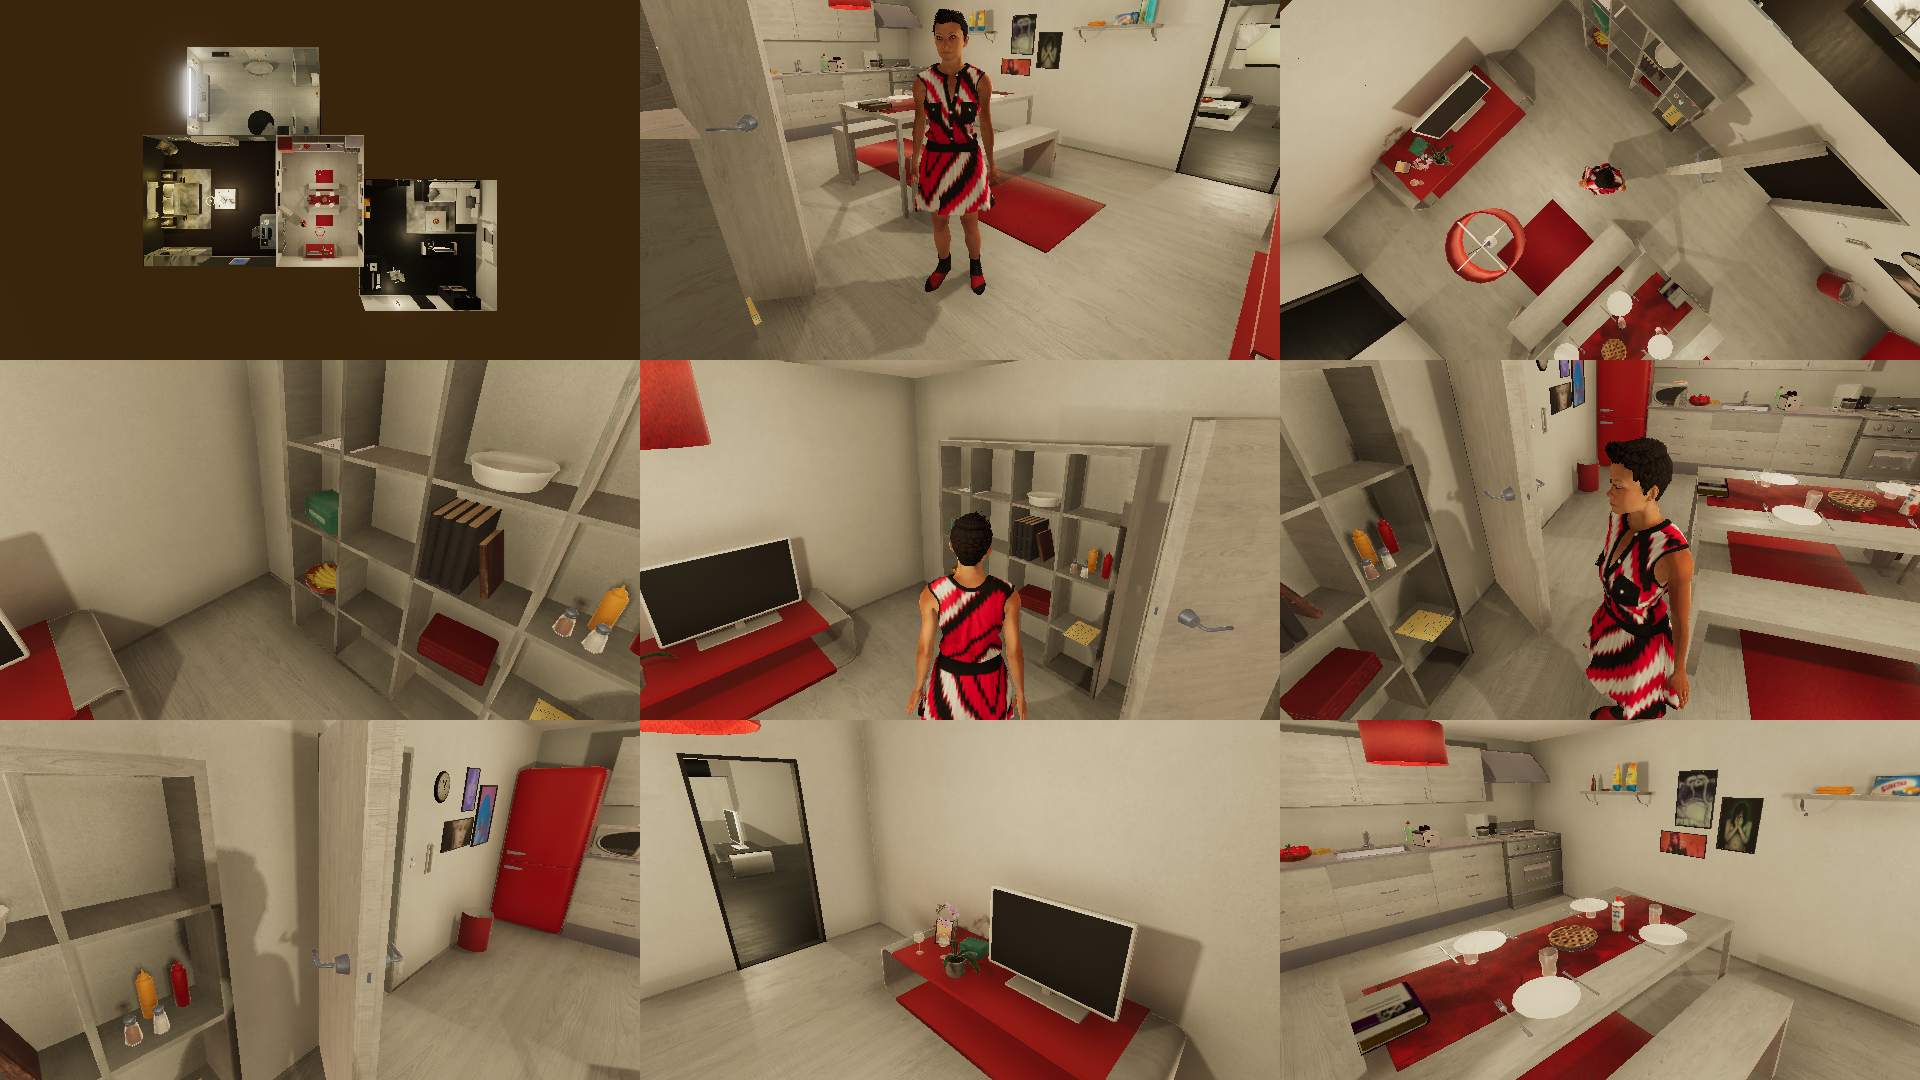

In [125]:
import json
import numpy as np

state_index = {'OPEN': 0, 'CLOSED': 1, 'ON': 2, 'OFF': 3, 'CLEAN':4}
room = {'bathroom', 'kitchen', 'livingroom', 'bedroom'}
comm.reset(0)
character_id = create_character('chars/Female2', 'kitchen')

properties = open('./resources/properties_data_all.json')
properties = json.load(properties)
properties['bathroom'] = []
properties['kitchen'] = []
properties['livingroom'] = []
properties['bedroom'] = []
properties['kitchencounterdrawer'] = properties.pop('kitchencounterdrawers')


_, graph = comm.environment_graph()
rooms_id = get_rooms_id(graph)
visible_objects_id = get_visible_objects_id(character_id, graph)
visible_objects_id = visible_objects_id.union(rooms_id)
partial_observation = get_observations(character_id, visible_objects_id, graph)
object_relationships = get_relationships(character_id, partial_observation, graph)

_, nc = comm.camera_count()
indices = range(nc - 9, nc)
imgs_prev = get_scene_cameras(comm, indices)
display_grid_img(imgs_prev, nrows=3)

## Extract data

In [126]:
import torch
def convert_script(raw_script):
    script = []
    for raw_script_instruction in raw_script:
        raw_script_instruction = raw_script_instruction[1: -2]
        word = raw_script_instruction.split(' ')
        if word[0].lower() == 'turnon':
            word[0] = 'switchon'
        if word[0].lower() == 'turnoff':
            word[0] = 'switchoff'
        script_instruction = '<char{}> [{}]'.format(word[-1][-1], word[0].lower())
        for obj in word[1: -1]:
            obj = obj.split('_')
            script_instruction += ' <{}> ({})'.format(obj[0].lower(), obj[1])
        script.append(script_instruction)
    return script

def stack_np_array_on_base(arr, base):
    ex_arr = np.expand_dims(arr, 0)
    return np.vstack([ex_arr, base]) if base is not None else ex_arr

In [127]:
path = "/content/drive/MyDrive/Dataset/lm_vh/metadata/method.json" # sample data of action/goal list
f = open(path)
goal_scripts = json.load(f)

#COMMENT THIS OUR FOR REAL RUN
goal_scripts = {
    '(and (ontop hanger_144 plate_195) (inside chair_109 clothespile_396) (grabbed character_1 clothespile_396) (grabbed character_2 towelrack_43))': ['(WALK BATHROOM_11 CHARACTER_2)\n', '(WALK TOWELRACK_43 CHARACTER_2)\n', '(GRAB TOWELRACK_43 CHARACTER_2)\n', '(WALK LIVINGROOM_336 CHARACTER_1)\n', '(WALK CLOTHESPILE_396 CHARACTER_1)\n', '(GRAB CLOTHESPILE_396 CHARACTER_1)\n', '(OPEN CLOTHESPILE_396 CHARACTER_1)\n', '(WALK KITCHEN_207 CHARACTER_1)\n', '(WALK CHAIR_109 CHARACTER_1)\n', '(GRAB CHAIR_109 CHARACTER_1)\n', '(PUTIN CHAIR_109 CLOTHESPILE_396 CHARACTER_1)\n', '(WALK BEDROOM_74 CHARACTER_1)\n', '(WALK CLOSET_129 CHARACTER_1)\n', '(OPEN CLOSET_129 CHARACTER_1)\n', '(WALK HANGER_144 CHARACTER_1)\n', '(GRAB HANGER_144 CHARACTER_1)\n', '(WALK KITCHEN_207 CHARACTER_1)\n', '(WALK PLATE_195 CHARACTER_1)\n', '(PUT HANGER_144 PLATE_195 CHARACTER_1)\n']
}

In [128]:
#hardcode sample data
import itertools, collections


action_index = {'standup': 0, 'walk': 1, 'sit': 2, 'grab': 3, 'open': 4, 'close': 5, 'switchon': 6, 'switchoff': 7, 'put': 8, 'putin': 9}
char_index = {'char1':0, 'char2':1}

data = {'goal': [], 
        'history': [], 
        'obs_ids': None, 
        'obs_names': [],
        'obs_states': None,
        'obs_positions': None,
        'relationships': [],
        'char_label': None, 
        'action_label': None, 
        'object_label': None}

for goal in goal_scripts:
    history = []
    comm.reset(2)
    #setup initial characters
    character_ids = [create_character('chars/Female2', 'kitchen'), create_character('chars/Male2', 'livingroom')]

    goal_scripts[goal] = convert_script(goal_scripts[goal])
    for script_instruction in goal_scripts[goal]:
        _, graph = comm.environment_graph()
        rooms_id = get_rooms_id(graph)

        total_partial_observations = collections.defaultdict(list)
        total_object_relationships = []
        for i in range(len(character_ids)): #iterate 2 chracters
            visible_objects_id = get_visible_objects_id(character_ids[i], graph).union(rooms_id)
            partial_observation = get_observations(character_ids[i], visible_objects_id, graph)
            for k in partial_observation:
                total_partial_observations[k] += partial_observation[k]
            total_object_relationships += [get_relationships(character_ids[i], partial_observation, graph)]
        
        #to numpy
        for k in total_partial_observations:
            if k == 'names': continue
            total_partial_observations[k] = np.array(total_partial_observations[k])
        
        word = script_instruction.split(' ')
        char = word[0][1: -1]
        char_label = np.array([char_index[char]])
        action = word[1][1: -1]
        action_label = np.array([action_index[action]])
        object_label = []

        try: # terminate the current goal and action list if object does not appear in partial observation
            if len(word) == 2:
                object_label = [0, 0] #0 is reserved for no such object involved

            elif len(word) == 4: 
                obj_id = int(word[3][1: -1])
                inds = np.where(total_partial_observations['ids']==obj_id)[0]
                # find the same obj index which the correct character interacts with
                obj = inds[char_label].item() if len(inds) > 1 else inds.item() 
                object_label = [obj, 0]    

            elif len(word) == 6:
                obj_id1 = int(word[3][1: -1])
                obj_id2 = int(word[5][1: -1])
                ind_a = np.where(total_partial_observations['ids']==obj_id1)[0]
                ind_b = np.where(total_partial_observations['ids']==obj_id2)[0]
                obj_a = ind_a[char_label].item() if len(ind_a) > 1 else ind_b.item()
                obj_b = ind_b[char_label].item() if len(ind_a) > 1 else ind_b.item()
                object_label = [obj_a, obj_b]
        except:
            break

        object_label = np.array(object_label)
        data['goal'] += [goal_translate(goal)]
        data['history'] += [history_translate(history)]
        for key in total_partial_observations:
            if key == 'names': continue
            data['obs_{}'.format(key)] = stack_np_array_on_base(total_partial_observations[key], data['obs_{}'.format(key)])
        data['obs_names'] += [" ".join(list(total_partial_observations['names']))]
        data['relationships'] += [total_object_relationships]
        data['char_label'] = stack_np_array_on_base(char_label, data['char_label'])
        data['action_label'] = stack_np_array_on_base(action_label, data['action_label'])
        data['object_label'] = stack_np_array_on_base(object_label, data['object_label'])

        history.append(script_instruction)
        comm.render_script([script_instruction], recording=False, skip_animation=True)

In [129]:
print('Environment data collected:')
for key in data:
    print("key = {}, shape = ".format(key), end =' ')
    if type(data[key]) is list:
        print(len(data[key]))
    else:
        print(data[key].shape)

Environment data collected:
key = goal, shape =  19
key = history, shape =  19
key = obs_ids, shape =  (19, 512)
key = obs_names, shape =  19
key = obs_states, shape =  (19, 512, 6)
key = obs_positions, shape =  (19, 512, 6)
key = relationships, shape =  19
key = char_label, shape =  (19, 1)
key = action_label, shape =  (19, 1)
key = object_label, shape =  (19, 2)


In [142]:
#save sample data
import json 
import os 

save_dir = '/content/drive/MyDrive/Dataset/lm_vh/sample_data'
!mkdir -p $save_dir
for key in data:
    if key == 'relationships':
        with open(os.path.join(save_dir, 'relationships'), 'w') as f:
            f.write(json.dumps(data['relationships']))
            f.close()
    else:
        np.save(os.path.join(save_dir, key), data[key])

# Training

## Data loader and preprocess

In [71]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 12.0 MB/s 
     |████████████████████████████████| 596 kB 36.5 MB/s 
     |████████████████████████████████| 895 kB 37.6 MB/s 
     |████████████████████████████████| 77 kB 5.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [72]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2Model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [131]:
data_pth = '/content/drive/MyDrive/Dataset/lm_vh/sample_data'

In [143]:
class VHStructuredDataset(Dataset):
        def __init__(self, data_pth):
            self.data = {}
            for key in data:
                if key == 'relationships': continue
                self.data[key] = np.load(os.path.join(data_pth,"{}.npy".format(key)), allow_pickle=True)

                
        def __getitem__(self, index):
            goal = self.data['goal'][index]
            history = self.data['history'][index]
            obs_ids = self.data['obs_ids'][index]
            obs_names = self.data['obs_names'][index] 
            obs_states = self.data['obs_states'][index]
            obs_positions = self.data['obs_positions'][index]
            char_label = self.data['char_label'][index]
            action_label = self.data['action_label'][index]
            object_label = self.data['object_label'][index]

            return {'goal': goal,
                    'history': history,
                    'obs_ids': obs_ids,
                    'obs_names': obs_names,
                    'obs_states': obs_states,
                    'obs_positions': obs_positions,
                    'char_label':char_label,
                    'action_label':action_label,
                    'object_label':object_label}
            
        def __len__(self):
            return len(self.data['goal'])

In [144]:
#load relationships
relationsips = None
with open(os.path.join(data_pth, 'relationships'), 'r') as f:
    relationships = json.load(f)

In [145]:
dataset = VHStructuredDataset(data_pth)
train_loader = DataLoader(dataset, batch_size=4, num_workers=2)

In [146]:
i = 0
for batch_ndx, sample in enumerate(train_loader):
    print(batch_ndx)
    print(sample['char_label'])


0
tensor([[0],
        [0],
        [0],
        [0]])
1
tensor([[0],
        [0],
        [0],
        [0]])
2
tensor([[0],
        [0],
        [0],
        [0]])
3
tensor([[0],
        [0],
        [0],
        [0]])
4
tensor([[1],
        [1],
        [1]])


## Define preprocessing procedure

In [27]:
def get_tokenizer(lm):
    tokenizer = GPT2Tokenizer.from_pretrained(lm)
    return tokenizer

def get_word_embeddings(lm):
    model = GPT2Model.from_pretrained(lm)
    word_embeddings = model.wte.weight
    return word_embeddings

def embed(sentence, tokenizer, word_embeddings, max_len=128):
    #list sentence arg can be like ['I have a pen', 'I have an apple']
    tokenized = gpt2_tokenizer(sentence, max_length=max_len, pad_to_max_length=True, return_tensors="pt").input_ids.to(device)
    one_hot_tokenized = F.one_hot(tokenized, num_classes=50257).type(torch.float32)
    embeddings = one_hot_tokenized @ gpt2_word_embeddings
    return embeddings

def preprocess(data, tokenizer, embeddings):
    data['goal'] = embed(data['goal'], tokenizer, embeddings, max_len = 32)
    data['history'] = embed(data['history'], tokenizer, embeddings, max_len = 64)
    data['obs_names'] = embed(data['obs_names'], tokenizer, embeddings, max_len = 256)
    data['obs_states'] = data['obs_states'].type(torch.float32).to(device)
    data['obs_positions'] = data['obs_positions'].type(torch.float32).to(device)
    data['action_label'] = data['action_label'].to(device).squeeze()
    data['object_label'] = data['object_label'].to(device)
    return data

In [28]:
#define tokenizer and embedders
gpt2_tokenizer = get_tokenizer('gpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_word_embeddings = get_word_embeddings('gpt2').to(device)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

## Define Model

In [29]:
action_space = {0: 'standup', 1: 'walk', 2:'sit', 3:'grab', 4:'open', 5:'close', 6:'switchon', 7:'switchoff', 8:'put', 9: 'putin'}

def judge_standup(sitting_edges):
    return len(sitting_edges) > 1

def judge_walk(sitting_edges, inside_edges, hold_edges, obj, index):
    cond1 = len(sitting_edges) == 0
    cond2 = index not in inside_edges
    cond3 = obj in room
    cond4 = index not in hold_edges
    return cond1 and (cond2 or cond3) and cond4 

def judge_sit(sitting_edges, close_edges, obj, index):
    cond1 = len(sitting_edges) == 0
    cond2 = index in close_edges
    cond3 = 'SITTABLE' in properties[obj] if obj in properties else False
    return cond1 and cond2 and cond3

def judge_grab(close_edges, inside_edges, hold_edges, obj, index):
    cond1 = 'GRABBABLE' in properties[obj] if obj in properties else False
    cond2 = obj != 'water'
    cond3 = index in close_edges
    cond4 = index not in inside_edges
    cond5 = index not in hold_edges
    cond6 = len(hold_edges) < 2
    return cond1 and cond2 and cond3 and cond4 and cond5 and cond6

def judge_open(observations, close_edges, inside_edges, hold_edges, obj, index):
    cond1 = 'CAN_OPEN' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][1] = 1
    cond3 = index in close_edges
    cond4 = index not in inside_edges
    cond5 = index not in hold_edges
    cond6 = len(hold_edges) < 2
    return True if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 else False

def judge_close(observations, close_edges, inside_edges, hold_edges, obj, index):
    cond1 = 'CAN_OPEN' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][0] = 1
    cond3 = index in close_edges
    cond4 = index not in inside_edges
    cond5 = index not in hold_edges
    cond6 = len(hold_edges) < 2
    return True if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 else False

def judge_switchon(observations, close_edges, obj, index):
    cond1 = 'HAS_SWITCH' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][3] == 1
    cond3 = index in close_edges
    return True if cond1 and cond2 and cond3 else False

def judge_switchoff(observations, close_edges, obj, index):
    cond1 = 'HAS_SWITCH' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][2] == 1
    cond3 = index in close_edges
    return True if cond1 and cond2 and cond3 else False

def judge_put(hold_edges, close_edges, index1, index2):
    cond1 = index1 in hold_edges
    cond2 = index2 in close_edges
    return True if cond1 and cond2 else False

def judge_putin(observations, hold_edges, close_edges, index1, index2):
    cond1 = index1 in hold_edges
    cond2 = index2 in close_edges
    cond3 = observations[index2]['state'][1] != 1
    return True if cond1 and cond2 and cond3 else False

def judge_0(relationships):
    sitting_edges = relationships['sitting']
    return judge_standup(sitting_edges)

def judge_1(action, obj, index, relationships, observations):
    sitting_edges = relationships['sitting']
    close_edges = relationships['close']
    inside_edges = relationships['inside']
    hold_edges = relationships['hold']
    if action == 'walk':
        return judge_walk(sitting_edges, inside_edges, hold_edges, obj, index)
    elif action == 'sit':
        return judge_sit(sitting_edges, close_edges, obj, index)
    elif action == 'grab':
        return judge_grab(close_edges, inside_edges, hold_edges, obj, index)
    elif action == 'open':
        return judge_open(observations, close_edges, inside_edges, hold_edges, obj, index)
    elif action == 'close':
        judge_close(observations, close_edges, inside_edges, hold_edges, obj, index)
    elif action == 'switchon':
        return judge_switchon(observations, close_edges, obj, index)
    elif action == 'switchoff':
        return judge_switchoff(observations, close_edges, obj, index)

def judge_2(action, index1, index2, relationships, observations):
    close_edges = relationships['close']
    hold_edges = relationships['hold']
    if action == 'put':
        return judge_put(hold_edges, close_edges, index1, index2)
    elif action == 'putin':
        judge_putin(observations, hold_edges, close_edges, index1, index2)

In [30]:
class LMDecisionMaker(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layer in LM framework
        self.state_fc = nn.Linear(6, 768).to(device)
        self.position_fc1 = nn.Linear(6, 768).to(device)
        self.relu = nn.ReLU(inplace = True)
        self.position_fc2 = nn.Linear(768,  768).to(device)
        self.object_fc = nn.Linear(3 * 768, 768).to(device)
        self.action_fc = nn.Linear(768, 10).to(device)
        self.lm = GPT2Model.from_pretrained('gpt2').to(device)
    
    def lm_infer(self, input):
        return self.lm(inputs_embeds=input).last_hidden_state

    def forward(self, goal, history, obs_ids, obs_names, obs_states, obs_positions, relationships, action_label, object_label, train_or_test='train'):
        
        goal_embeddings = goal
        
        history_embeddings = history
        
        name_embeddings = obs_names.unsqueeze(2)
        
        state_embeddings = self.state_fc(obs_states).unsqueeze(2)
        
        position_embeddings = self.position_fc2(self.relu(self.position_fc1(obs_positions))).unsqueeze(2)
        
        observation_embeddings = torch.cat((name_embeddings, state_embeddings, position_embeddings), 2)
        observation_embeddings = observation_embeddings.view(-1, 256, 3*768)
        observation_embeddings = self.object_fc(observation_embeddings)
        
        action_embeddings = torch.cat((goal_embeddings, history_embeddings, observation_embeddings),1)
        action_embeddings = self.lm_infer(action_embeddings)

        contextualized_feature = torch.mean(action_embeddings, 1)
        contextualized_feature_after_fc = self.action_fc(contextualized_feature) # N*768

        object_feature = self.lm_infer(observation_embeddings) # N*L*768

        action_prediction = torch.argsort(contextualized_feature_after_fc, descending=True) # N*10

        repeated_cf = contextualized_feature.unsqueeze(1).repeat(1,object_feature.shape[1], 1)
        inner_product = torch.sum(object_feature*repeated_cf, axis = -1) # N*L
        object_prediction = torch.argsort(inner_product, descending=True)

        loss = self.compute_loss(contextualized_feature_after_fc, inner_product, action_label, object_label)
        '''
        next_predicate, next_index = self.predictor(action_prediction, object_prediction, batch_observations, batch_relationships)
        if train_or_test == 'train':
            loss = self.compute_loss(contextualized_feature_after_fc, inner_product, action_label, object_label)
            accuracy = self.compute_accuracy(next_index, action_label, object_label)
            return loss, accuracy
        else:
            return next_predicate
        '''

        return loss

    def compute_loss(self, contextualized_feature_after_fc, inner_product, action_label, object_label):
        """
        Compute the cross entropy loss

        contextualized_feature_after_fc: a torch tensor with a size (10), showing the probability of 10 actions
        inner_product: a torch tensor with a size (len(observations)), showing the probability of all visible objects
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: the cross entropy loss of the action and objects
        """
        action_loss = F.cross_entropy(contextualized_feature_after_fc, action_label) 
        object_loss = F.cross_entropy(inner_product, object_label[:, 0]) \
                    + F.cross_entropy(inner_product, object_label[:, 1])
        return action_loss + 1e-3*object_loss # rescale for it is super big 

    def compute_accuracy(self, next_index, action_label, object_label):
        """
        Compute the accuracy

        next_index: a tuple with three torch tensors with size (1), each indicates the index of the action and objects
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: the cross entropy loss of the action and objects
        """
        if object_label.shape[0] == 0:
            action_accuracy = 1 if int(next_index[0].cpu().numpy()) == int(action_label[0].cpu().numpy()) else 0
            return action_accuracy
        elif object_label.shape[0] == 1:
            action_accuracy = 0.5 if int(next_index[0].cpu().numpy()) == int(action_label[0].cpu().numpy()) else 0
            object_accuracy = 0.5 if int(next_index[1].cpu().numpy()) == int(object_label[0].cpu().numpy()) else 0
            return action_accuracy + object_accuracy
        elif object_label.shape[0] == 2:
            action_accuracy = 1/3 if int(next_index[0].cpu().numpy()) == int(action_label[0].cpu().numpy()) else 0
            object_accuracy1 = 1/3 if int(next_index[1].cpu().numpy()) == int(object_label[0].cpu().numpy()) else 0
            object_accuracy2 = 1/3 if int(next_index[2].cpu().numpy()) == int(object_label[1].cpu().numpy()) else 0
            return action_accuracy + object_accuracy1 + object_accuracy2

In [31]:
#define model
lm = LMDecisionMaker()

In [32]:
for batch_ndx, data in enumerate(train_loader):
    data = preprocess(data, gpt2_tokenizer, gpt2_word_embeddings )
    loss = lm.forward(**data)
    print(loss)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor(26.3383, device='cuda:0', grad_fn=<AddBackward0>)


In [33]:
import gc 
with torch.no_grad():
    torch.cuda.empty_cache()
    gc.collect()

## Define Language Model

Define the function to add constraints on the action and object predictions

Training and evaluating algorithm

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as f

def array_to_2d_tensor(array):
    if len(array.shape) > 1:
        return torch.tensor(array).to(device)
    return torch.tensor(array).unsqueeze(0).to(device)

def gpt2_model(embeddings):
    model = GPT2Model.from_pretrained('gpt2').to(device)
    return model(inputs_embeds=embeddings).last_hidden_state # N*768 N-> length of the info max 1024 => 1023*768

class LM(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layer in LM framework
        self.state_fc = nn.Linear(6, 3 * 768)

        self.position_fc1 = nn.Linear(6, 3 * 768)
        self.relu = nn.ReLU(inplace=True)
        self.position_fc2 = nn.Linear(3 * 768, 3 * 768)

        self.object_fc = nn.Linear(7 * 768, 768) #->obj label?

        self.action_fc = nn.Linear(768, 10)

    def forward(self, batch_goal, batch_history, batch_observations, batch_relationships, batch_action_label, batch_object_label, train_or_test='train'):
        """
        Forward pass of the neural network

        return: a tuple (loss, accuracy) of two torch Float scalars representing the cross entropy loss and mean accuracy of the batch
        """
        start = time.time()
        templated_goals = [goal_translate(goal) for goal in batch_goal]
        templated_histories = [history_translate(history) for history in batch_history]
        end = time.time()
        print("Template Translation : {}".format(end-start))

        # embed goal
        start = time.time()
        goal_embeddings = batch_embed(templated_goals, gpt2_tokenizer, gpt2_word_embeddings)
        end = time.time()
        print("Goal Embedding: {}".format(end-start))
        print("Shape:{}".format(goal_embeddings.shape))
        
        # embed history
        start = time.time()
        history_embeddings = batch_embed(templated_histories, gpt2_tokenizer, gpt2_word_embeddings)
        end = time.time()
        print("History Embedding: {}".format(end-start))
        print("Shape:{}".format(history_embeddings.shape)) # N*12*768
        
        # embed partial observation
        start = time.time()
        observation_embeddings = []
        for visible_object in batch_observations.values():
            # embed name
            name_embeddings = batch_embed(visible_object['name'], gpt2_tokenizer, gpt2_word_embeddings)
            name_embeddings = torch.mean(name_embeddings, -1)

            # embed state
            state = torch.tensor(visible_object['state'], dtype=torch.float).to(device)
            state_embeddings = self.state_fc(state).unsqueeze(0)

            # embed position
            position = torch.tensor(visible_object['position'], dtype=torch.float).to(device)
            position_embeddings = self.position_fc1(position)
            position_embeddings = self.relu(position_embeddings)
            position_embeddings = self.position_fc2(position_embeddings).unsqueeze(0)

            # concatenate object embeddings and pass through fc layer
            object_embeddings = torch.cat((name_embeddings, state_embeddings, position_embeddings), 1)
            object_embeddings = self.object_fc(object_embeddings).view(-1, 768)
            observation_embeddings.append(object_embeddings)

        # concatenate all object embeddings
        observation_embeddings = torch.cat(observation_embeddings)
        end = time.time()
        print("Obs Embedding: {}".format(end-start))
        print("Shape:{}".format(observation_embeddings.shape))

        # concatenate goal, history and observations and pass them through LM
        start = time.time()
        action_embeddings = torch.cat((goal_embeddings, history_embeddings, observation_embeddings))
        action_embeddings = gpt2_model(action_embeddings[:1023])
        end = time.time()
        print("action embedding: {}".format(end-start))

        # pass LM output to the average pooling to get contextualized feature and predict the next action
        contextualized_feature = torch.mean(action_embeddings, 0)
        contextualized_feature_after_fc = self.action_fc(contextualized_feature)
        action_prediction = torch.argsort(contextualized_feature_after_fc, descending=True)

        # pass the observation embeddings through LM and compute the inner product of each object feature with contextualized feature, then make the object prediction
        start = time.time()
        object_feature = gpt2_model(observation_embeddings[:1023])
        end = time.time()
        print("obj feature: {}".format(end-start))
        inner_product = object_feature.unsqueeze(1).bmm(contextualized_feature.repeat(object_feature.shape[0]).view(object_feature.shape[0], -1, 1)).squeeze()
        object_prediction = torch.argsort(inner_product, descending=True)

        next_predicate, next_index = self.predictor(action_prediction, object_prediction, batch_observations, batch_relationships)
        if train_or_test == 'train':
            loss = self.compute_loss(contextualized_feature_after_fc, inner_product, action_label, object_label)
            accuracy = self.compute_accuracy(next_index, action_label, object_label)
            return loss, accuracy
        else:
            return next_predicate
  
    def predictor(self, action_prediction, object_prediction, observations, relationships):
        """
        Compute the loss and accuracy

        action_prediction: a torch tensor with a size (10), showing the probability of 10 actions
        object_prediction: a torch tensor with a size (len(observations)), showing the probability of all visible objects
        observations: a dictionary mapping the visible object (including all rooms) id to name, state vector and position vector
        relationships: a dictionary containing 4 relationship dictionary: sitting, close, inside, hold

        return: a predicate string in the form of VirtualHome format without character, e.g. '[walk] <chair> (1)'
        """
        for action_id in action_prediction:
            if int(action_id.cpu().numpy()) == 0 and judge_0(relationships):
                return '[{}]'.format(action_space[int(action_id.cpu().numpy())]), (action_id, torch.tensor([-1]).to(device), torch.tensor([-1]).to(device))

            elif 1 <= int(action_id.cpu().numpy()) <= 7:
                action = action_space[int(action_id.cpu().numpy())]
                for object_id in object_prediction:
                    obj = observations[list(observations.keys())[int(object_id.cpu().numpy())]]['name']
                    index = list(observations.keys())[int(object_id.cpu().numpy())]
                    if judge_1(action, obj, index, relationships, observations):
                        return '[{}] <{}> ({})'.format(action, obj, index), (action_id, object_id, torch.tensor([-1]).to(device))

            elif int(action_id.cpu().numpy()) >= 8:
                action = action_space[int(action_id.cpu().numpy())]
                for i in range(len(object_prediction)):
                    obj1 = observations[list(observations.keys())[int(object_prediction[i].cpu().numpy())]]['name']
                    index1 = list(observations.keys())[int(object_prediction[i].cpu().numpy())]
                    for j in range(i + 1, len(object_prediction)):
                        obj2 = observations[list(observations.keys())[int(object_prediction[j].cpu().numpy())]]['name']
                        index2 = list(observations.keys())[int(object_prediction[j].cpu().numpy())]
                        if judge_2(action, index1, index2, relationships, observations):
                            return '[{}] <{}> ({}) <{}> ({})'.format(action, obj1, index1, obj2, index2), (action_id, object_prediction[i], object_prediction[j])
            
    def compute_loss(self, contextualized_feature_after_fc, inner_product, action_label, object_label):
        """
        Compute the cross entropy loss

        contextualized_feature_after_fc: a torch tensor with a size (10), showing the probability of 10 actions
        inner_product: a torch tensor with a size (len(observations)), showing the probability of all visible objects
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: the cross entropy loss of the action and objects
        """
        if object_label.shape[0] == 0:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label)
        elif object_label.shape[0] == 1:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label) + f.cross_entropy(inner_product.unsqueeze(0), object_label)
        elif object_label.shape[0] == 2:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label) + f.cross_entropy(inner_product.unsqueeze(0), object_label[0].unsqueeze(0)) + f.cross_entropy(inner_product.unsqueeze(0), object_label[1].unsqueeze(0))

    def compute_accuracy(self, next_index, action_label, object_label):
        """
        Compute the accuracy

        next_index: a tuple with three torch tensors with size (1), each indicates the index of the action and objects
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: the cross entropy loss of the action and objects
        """
        if object_label.shape[0] == 0:
            action_accuracy = 1 if int(next_index[0].cpu().numpy()) == int(action_label[0].cpu().numpy()) else 0
            return action_accuracy
        elif object_label.shape[0] == 1:
            action_accuracy = 0.5 if int(next_index[0].cpu().numpy()) == int(action_label[0].cpu().numpy()) else 0
            object_accuracy = 0.5 if int(next_index[1].cpu().numpy()) == int(object_label[0].cpu().numpy()) else 0
            return action_accuracy + object_accuracy
        elif object_label.shape[0] == 2:
            action_accuracy = 1/3 if int(next_index[0].cpu().numpy()) == int(action_label[0].cpu().numpy()) else 0
            object_accuracy1 = 1/3 if int(next_index[1].cpu().numpy()) == int(object_label[0].cpu().numpy()) else 0
            object_accuracy2 = 1/3 if int(next_index[2].cpu().numpy()) == int(object_label[1].cpu().numpy()) else 0
            return action_accuracy + object_accuracy1 + object_accuracy2

def train(net, num_steps):
    """
    Train the input neural network for num_steps

    net: LM framework
    num_steps: number of batches to train for

    return: the trained net, the training accuracies per step, and the validation accuracies per steps
    """
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)
    train_accuracies = []
    val_accuracies = []
    for step, batch in zip(range(num_steps), train_dataset):
        train_loss = torch.tensor([0], dtype=torch.float).to(device)
        train_accuracy = 0
        batch_size = batch.shape[0]
        for data in batch:
            goal, history, observations, relationships, action_label, object_label = data['goal'], data['history'], data['observations'], data['relationships'], data['action_label'], data['object_label']
            loss, accuracy = net(goal, history, observations, relationships, action_label, object_label, 'train')

            train_loss += loss / batch_size
            train_accuracy += accuracy / batch_size

        opt.zero_grad()
        train_loss.backward()
        opt.step()

        train_accuracies.append(train_accuracy)
        if (step + 1) % 1 == 0:
            val_loss, val_accuracy = validate(net, val_dataset)
            val_accuracies.append(val_accuracy)
            print('step=%s   train(loss=%.5g, accuracy=%.5g)  val(loss=%.5g, accuracy=%.5g)' % (step + 1, train_loss, train_accuracy, val_loss, val_accuracy))
    return net, train_accuracies, val_accuracies

def validate(net, val_dataset):
    """
    Evalate the trained net on val_dataset

    net: LM framework
    val_dataset: validation dataset

    return: a tuple (val_loss, val_accuracy)
    """
    with torch.no_grad():
        batch = next(iter(val_dataset))
        batch_size = batch.shape[0]
        loss_sum = torch.tensor([0], dtype=torch.float).to(device)
        accuracy_sum = 0
        for data in batch:
            goal, history, observations, relationships, action_label, object_label = data['goal'], data['history'], data['observations'], data['relationships'], data['action_label'], data['object_label']
            loss, accuracy = net(goal, history, observations, relationships, action_label, object_label, 'train')

            loss_sum += loss / batch_size
            accuracy_sum += accuracy / batch_size

        val_loss, val_accuracy = loss_sum, accuracy_sum
    return val_loss, val_accuracy

In [ ]:
print("Launching training on {}".format(device))

Launching training on cuda


In [ ]:
nets = {}
train_steps = 10 # change as needed
plt.figure(figsize=(20, 10))

Net = LM
nets[Net], train_accs, val_accs = train(Net(), train_steps)

plt.plot((1 + np.arange(len(val_accs))), val_accs, label=Net.__name__)
plt.xlabel('training step')
plt.ylabel('validation accuracy')
plt.legend()
plt.show()

# Test the model

In [ ]:
test_goal = ['ON (coffeepot, kitchentable): 1']
test_hostory = []
success_predicate = ['[put] <coffeepot> <kitchentable>']
comm.reset(6)

character_id = create_character('chars/Female2', 'livingroom')
rooms_id = get_rooms_id()

num = 0
while num < 5:
    visible_objects_id = get_visible_objects_id(character_id)
    visible_objects_id = visible_objects_id.union(rooms_id)
    partial_observation = get_observations(character_id, visible_objects_id)
    object_relationships = get_relationships(character_id, partial_observation)

    next_predicate = nets[Net](test_goal, test_hostory, partial_observation, object_relationships, None, None, 'test')
    print(next_predicate)
    if next_predicate in success_predicate:
        break

    comm.render_script(['<char0> ' + next_predicate], recording=False, skip_animation=True)

    test_hostory.append(next_predicate)
    num += 1
print(test_hostory)